In [36]:
import collections
import matplotlib.pyplot as plt
from IPython import display
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from common.ffn.ffn_relu import ParametricReLUNet

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid


#### MNIST dataset

MNIST dataset is used which contains 60000 28x28 images of handwritten digits from 0 to 9. 

In [37]:
# use it to conver from PIL to torch.Tensor
image_transform = ToTensor()

train_dataset = MNIST(root='./', train=True, download=True, transform=image_transform)
test_dataset = MNIST(root='./', train=False, download=True, transform=image_transform)

In [38]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
)

Data example:

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])
Labels: [[3, 0, 2, 2, 5, 2, 7, 9], [8, 6, 0, 4, 1, 3, 6, 6], [3, 1, 3, 4, 9, 4, 6, 3], [8, 8, 8, 4, 3, 2, 3, 0]]


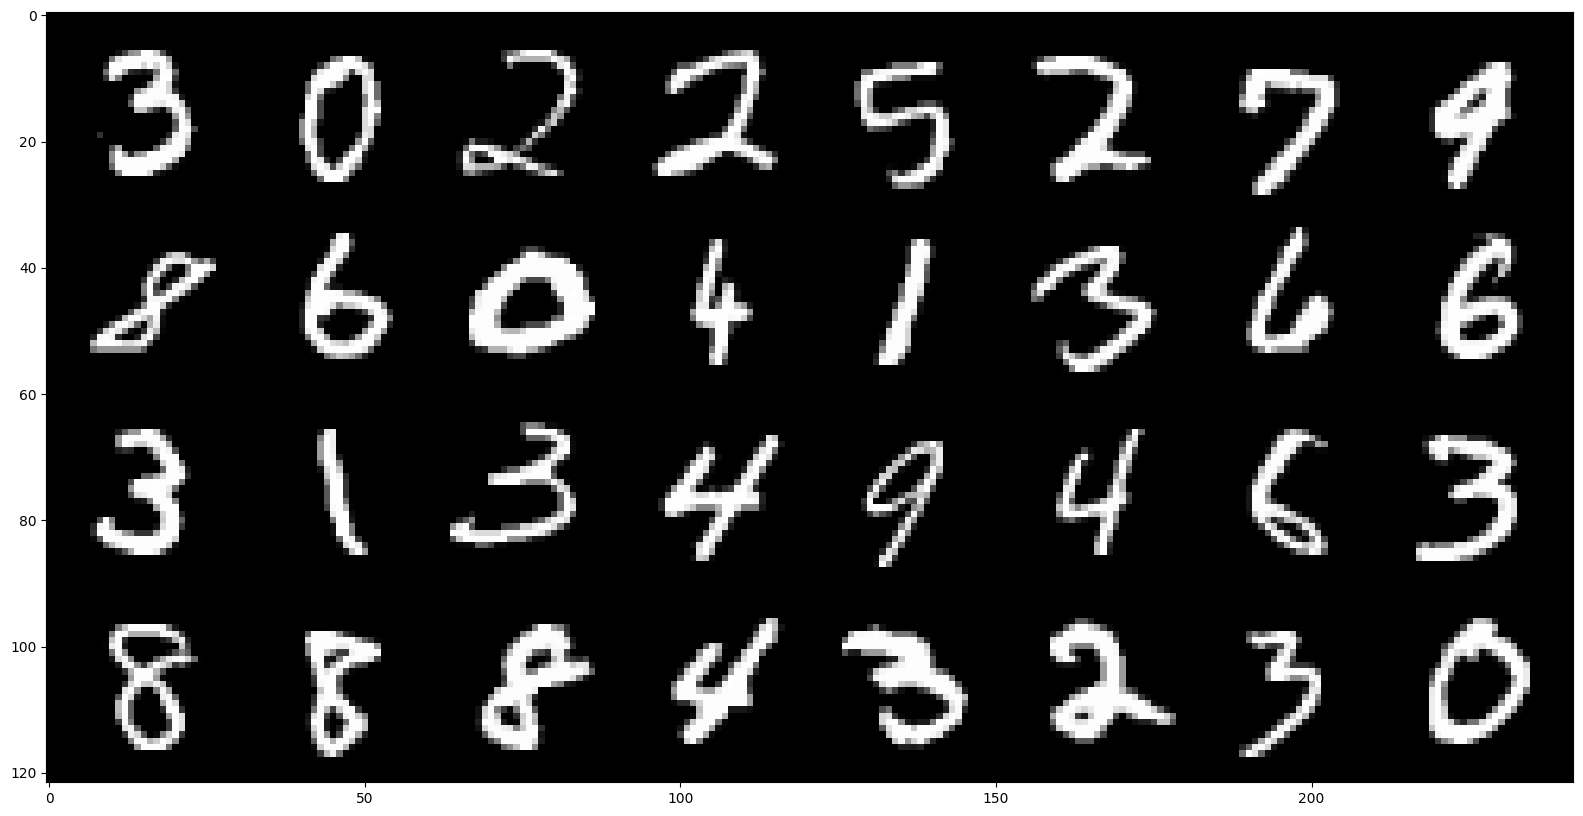

In [39]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
#img = train_features[0].squeeze()
images = make_grid(train_features, 8).permute(1, 2, 0)
labels = train_labels.view(-1, 8).tolist()
print(f"Labels: {labels}")
plt.figure(figsize=(20, 10))
plt.imshow(images, cmap="gray")
plt.show()


In [40]:
class AverageMeter:
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def calculate_accuracy(prediction, target):
    # Note that prediction.shape == target.shape == [B, ]
    
    matching = (prediction == target).float()
    return matching.mean()


#### FFN as a reference implementation

Typical implementation of image-recognition

FFN with 2 hidden layers: 
- nn.ReLU is an activation-function
- nn.Sequential is used to combine several layers into one model 

In [41]:
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
                
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)
        
    def forward(self, x):
        #x = [batch size, height, width]
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        #x = [batch size, height * width]
        h_1 = F.relu(self.input_fc(x))
        #h_1 = [batch size, 250]
        h_2 = F.relu(self.hidden_fc(h_1))
        #h_2 = [batch size, 100]
        y_pred = self.output_fc(h_2)
        #y_pred = [batch size, output dim]
        return y_pred, h_2


INPUT_DIM = 28 * 28
OUTPUT_DIM = 10  # num classes
H1, H2 = 250, 100

# HINT
# Use nn.Sequential, nn.Linear and nn.ReLU

### YOUR SOLUTION ###
model2 = MLP(INPUT_DIM, OUTPUT_DIM)

Cross-entropy loss and stochastic gradient descent optimiser are used. Descent is performed in number of epochs, no stop-criterion for gradient descent. Accuracy is a metric for the learninng process.

#### Experiment with FFN in non-criticality mode

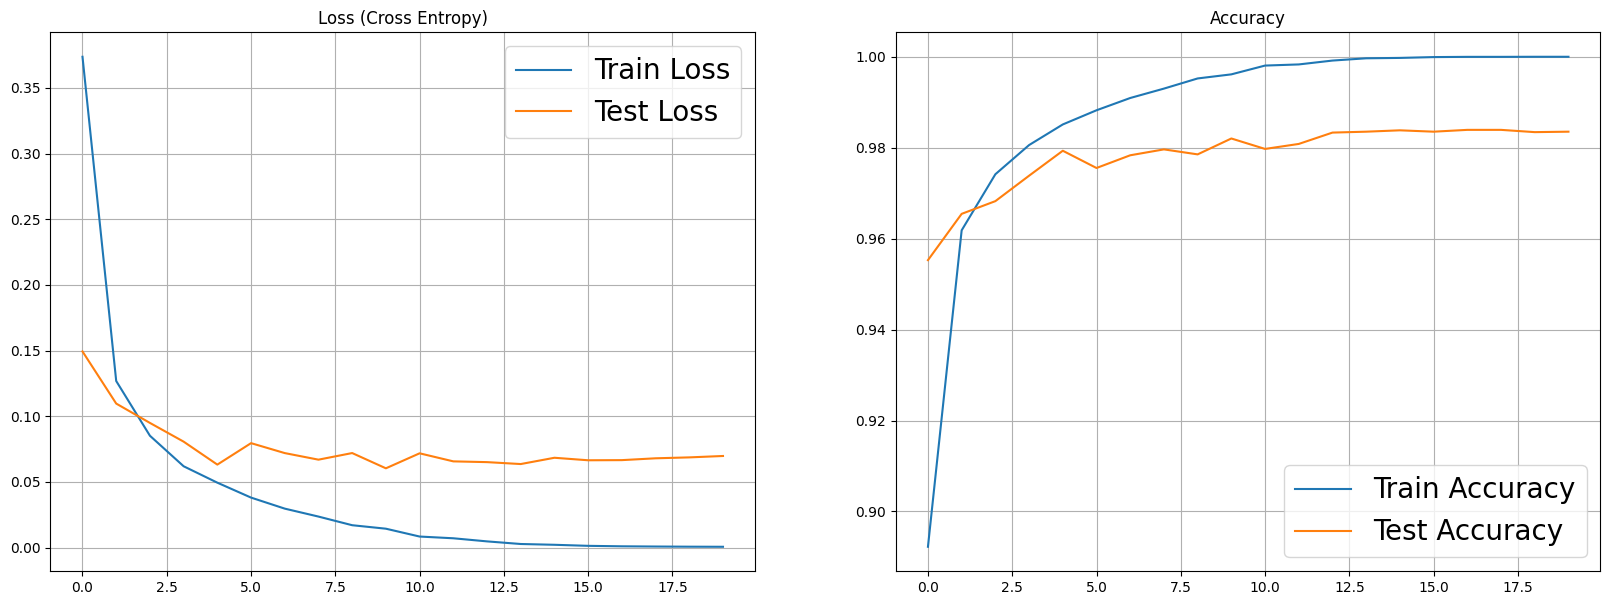

In [42]:
NUM_EPOCH = 20
HISTORY_NONCRITICALITY = collections.defaultdict(list)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=1e-2, momentum=0.9, nesterov=True)

DEVICE = torch.device('cpu')  # you can change to `cuda:0`
model2.to(DEVICE)

for epoch in range(NUM_EPOCH):
    # AverageMeter will accumulate average of some metric
    # Procceed to `utils.py` to see implementation
    train_loss_meter = AverageMeter()
    train_accuracy_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    test_accuracy_meter = AverageMeter()
    
    # training loop
    for train_batch in train_dataloader:
        
        # unpack batch and move to specific device (for example, GPU or TPU)
        images, labels = train_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        logits, _ = model2.forward(images)
        prediction = logits.argmax(dim=-1)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate current average loss and accuracy
        train_loss_meter.update(loss.item())
        train_accuracy_meter.update(
            calculate_accuracy(
                prediction.detach(),
                labels
            ).item()
        )
    #break
    # save average train loss and accuracy
    HISTORY_NONCRITICALITY['train_loss'].append(train_loss_meter.avg)
    HISTORY_NONCRITICALITY['train_accuracy'].append(train_accuracy_meter.avg)
        
    # testing loop
    for test_batch in test_dataloader:
        images, labels = test_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # аdd `with torch.no_grad()' to avoid computing gradients of weights
        with torch.no_grad():
            # do everything like we did in training loop
            logits, _ = model2(images)
            prediction = logits.argmax(dim=-1)
            loss = criterion(logits, labels)
        
        test_loss_meter.update(loss.item())
        test_accuracy_meter.update(
            calculate_accuracy(
                prediction,
                labels
            ).item()
        )
    
    # save average test accuracy loss and accuracy
    HISTORY_NONCRITICALITY['test_loss'].append(test_loss_meter.avg)
    HISTORY_NONCRITICALITY['test_accuracy'].append(test_accuracy_meter.avg)
    
    # visualize all together
    display.clear_output()
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    axes[0].set_title('Loss (Cross Entropy)')
    axes[0].plot(HISTORY_NONCRITICALITY['train_loss'], label='Train Loss')
    axes[0].plot(HISTORY_NONCRITICALITY['test_loss'], label='Test Loss')
    axes[0].grid()
    axes[0].legend(fontsize=20)
    
    axes[1].set_title('Accuracy')
    axes[1].plot(HISTORY_NONCRITICALITY['train_accuracy'], label='Train Accuracy')
    axes[1].plot(HISTORY_NONCRITICALITY['test_accuracy'], label='Test Accuracy')
    axes[1].grid()
    axes[1].legend(fontsize=20)
    
    plt.show()

In [43]:
print("Accuracy achieved in non-criticality FFN: "+str(HISTORY_NONCRITICALITY['test_accuracy'][-1]))

Accuracy achieved in non-criticality FFN: 0.983526357827476


The same experiment with the network at Relu-criticality; positive and negative relu slopes are 1 and 0

In [44]:
class MNISTReLU(ParametricReLUNet):
    def __init__(self, input_dim, output_dim):
        super().__init__(n0=input_dim,nk=0,nl=output_dim,l=0, bias_on=True)
                
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward_(self, x):
        return self.forward(x)

    def forward(self, x):
        #x = [batch size, height, width]
        #batch_size = x.shape[0]
        #x = x.view(batch_size, -1)
        #x = [batch size, height * width]
        h_1 = self.PReLU(self.input_fc(x))
        #h_1 = [batch size, 250]
        h_2 = self.PReLU(self.hidden_fc(h_1))
        #h_2 = [batch size, 100]
        y_pred = self.output_fc(h_2)
        #y_pred = [batch size, output dim]
        return y_pred
    
    def init_weights(self, cb=0.0, cw=1.0):
        if self.get_log_level() == "debug":
            print("FeedForwardNet weights initialisation with cb={}, cw={}".format(cb, cw))

        #Weight initialisation as in 2.19, 2.20
        self.cb, self.cw = cb, cw
        self.init_linear_weights(self.input_fc, self.bias_on, cb, cw/self.input_fc.in_features)
        self.init_linear_weights(self.hidden_fc, self.bias_on, cb, cw/self.hidden_fc.in_features)
        self.init_linear_weights(self.output_fc, self.bias_on, cb, cw/self.output_fc.in_features)


#### Experiment with FFN in criticality mode

In [45]:
NUM_EPOCH = 20
HISTORY_CRITICALITY = collections.defaultdict(list)

INPUT_DIM = 28 * 28
OUTPUT_DIM = 10  # num classes

#Weights distribution variances are set as in (5.67)
slope_plus, slope_minus=1.0, 0.0
cb, cw = 0, 2.0/(slope_plus**2.0 + slope_minus**2.0)

testNet = MNISTReLU(INPUT_DIM, OUTPUT_DIM) #ParametricReLUNet(n0=INPUT_DIM,nk=250,nl=OUTPUT_DIM,l=2, bias_on=True)
testNet.set_log_level("info")
testNet.set_slopes(slope_plus, slope_minus)
testNet.init_weights(cb, cw)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(testNet.parameters(), lr=1e-2, momentum=0.9, nesterov=True)

DEVICE = torch.device('cpu')  # you can change to `cuda:0`
testNet.to(DEVICE)

for epoch in range(NUM_EPOCH):
    # AverageMeter will accumulate average of some metric
    # Procceed to `utils.py` to see implementation
    train_loss_meter = AverageMeter()
    train_accuracy_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    test_accuracy_meter = AverageMeter()
    
    # training loop
    for train_batch in train_dataloader:
        
        # unpack batch and move to specific device (for example, GPU or TPU)
        images, labels = train_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        batch_size = images.shape[0]
        xx = images.view(batch_size, -1)
        logits = testNet.forward_(xx)
        prediction = logits.argmax(dim=-1)
        loss = criterion(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate current average loss and accuracy
        train_loss_meter.update(loss.item())
        train_accuracy_meter.update(
            calculate_accuracy(
                prediction.detach(),
                labels
            ).item()
        )
    #break
    # save average train loss and accuracy
    HISTORY_CRITICALITY['train_loss'].append(train_loss_meter.avg)
    HISTORY_CRITICALITY['train_accuracy'].append(train_accuracy_meter.avg)
        
    # testing loop
    for test_batch in test_dataloader:
        images, labels = test_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # аdd `with torch.no_grad()' to avoid computing gradients of weights
        with torch.no_grad():
            # do everything like we did in training loop
            batch_size = images.shape[0]
            xx = images.view(batch_size, -1)
            logits = testNet.forward_(xx)            
            prediction = logits.argmax(dim=-1)
            loss = criterion(logits, labels)
        
        test_loss_meter.update(loss.item())
        test_accuracy_meter.update(
            calculate_accuracy(
                prediction,
                labels
            ).item()
        )
    
    # save average test accuracy loss and accuracy
    HISTORY_CRITICALITY['test_loss'].append(test_loss_meter.avg)
    HISTORY_CRITICALITY['test_accuracy'].append(test_accuracy_meter.avg)
    
    # visualize all together
    display.clear_output()
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    axes[0].set_title('Loss (Cross Entropy)')
    axes[0].plot(HISTORY_CRITICALITY['train_loss'], label='Train Loss')
    axes[0].plot(HISTORY_CRITICALITY['test_loss'], label='Test Loss')
    axes[0].grid()
    axes[0].legend(fontsize=20)
    
    axes[1].set_title('Accuracy')
    axes[1].plot(HISTORY_CRITICALITY['train_accuracy'], label='Train Accuracy')
    axes[1].plot(HISTORY_CRITICALITY['test_accuracy'], label='Test Accuracy')
    axes[1].grid()
    axes[1].legend(fontsize=20)
    
    plt.show()

FeedForwardNet created with n0=784, nk=0, nl=10, l=0, bias_on=True


In [ ]:
print("Accuracy achieved in criticality FFN: "+str(HISTORY_CRITICALITY['test_accuracy'][-1]))

Accuracy achieved in criticality FFN: 0.9827276357827476


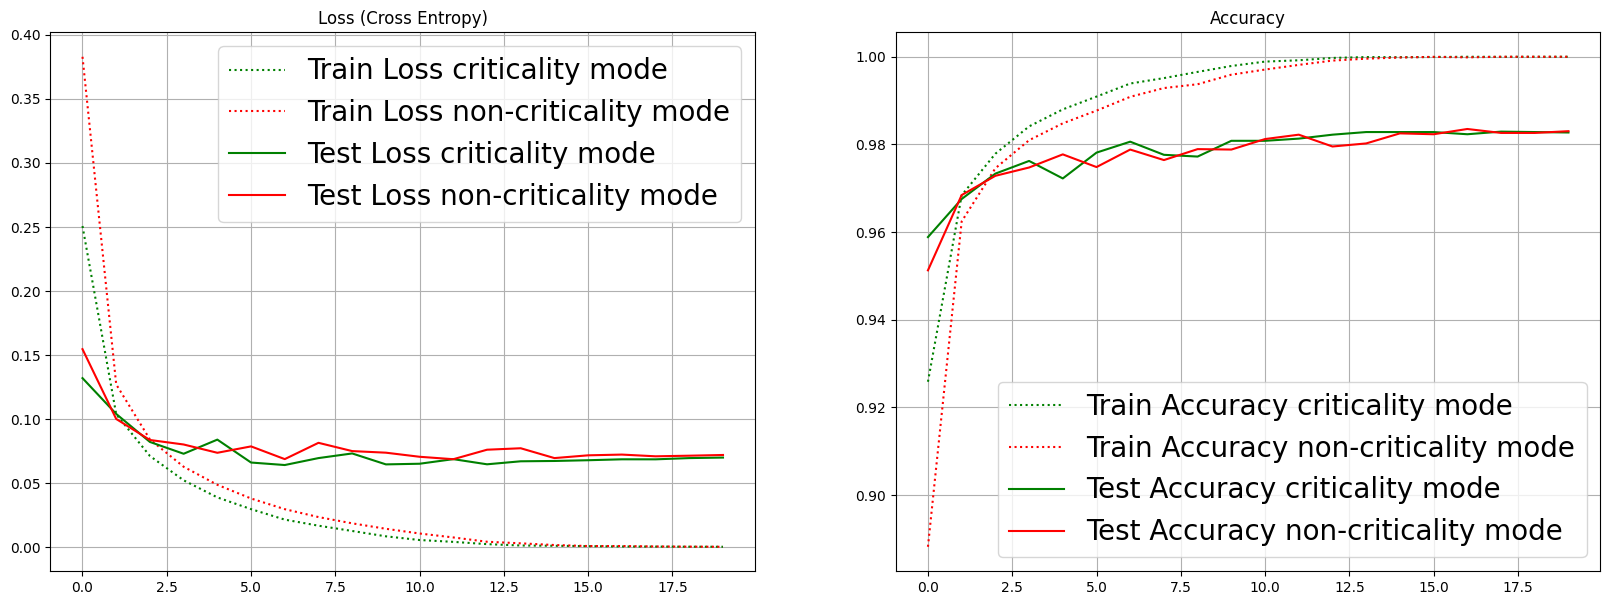

In [ ]:
display.clear_output()
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
axes[0].set_title('Loss (Cross Entropy)')
axes[0].plot(HISTORY_CRITICALITY['train_loss'], color='g', ls='dotted', label='Train Loss criticality mode')
axes[0].plot(HISTORY_NONCRITICALITY['train_loss'], color='r', ls='dotted', label='Train Loss non-criticality mode')
axes[0].plot(HISTORY_CRITICALITY['test_loss'], color='g', label='Test Loss criticality mode')
axes[0].plot(HISTORY_NONCRITICALITY['test_loss'], color='r', label='Test Loss non-criticality mode')
axes[0].grid()
axes[0].legend(fontsize=20)
axes[0].set_xlabel("Epoch (series of gradient descent steps)")
axes[0].set_ylabel("Loss value")

axes[1].set_title('Accuracy')
axes[1].plot(HISTORY_CRITICALITY['train_accuracy'], color='g', ls='dotted', label='Train Accuracy criticality mode')
axes[1].plot(HISTORY_NONCRITICALITY['train_accuracy'], color='r', ls='dotted', label='Train Accuracy non-criticality mode')
axes[1].plot(HISTORY_CRITICALITY['test_accuracy'], color='g', label='Test Accuracy criticality mode')
axes[1].plot(HISTORY_NONCRITICALITY['test_accuracy'], color='r', label='Test Accuracy non-criticality mode')
axes[1].grid()
axes[1].legend(fontsize=20)
axes[1].set_xlabel("Epoch (series of gradient descent steps)")
axes[1].set_ylabel("Accuracy value")

fig.tight_layout()
fig.subplots_adjust(top=0.95)
dummy=fig.suptitle("Comparison for the same FFN-architectures for criticality and non-criticality mode")

plt.show()